# (13) Fit -- cuda0

**Motivation**: Fitting notebook, cuda0 <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [2]:
vae = VAE(ConfigVAE(
    'fixate1', n_enc_cells=1, n_dec_cells=1, n_enc_nodes=3, n_dec_nodes=2,              
    n_latent_scales=3, n_groups_per_scale=8, n_latent_per_group=15,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.002, batch_size=500, epochs=200, grad_clip=500,
        warm_restart=0, warmup_portion=0.02,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-3, 
        kl_beta=0.20, kl_anneal_cycles=0, kl_anneal_portion=0.3, kl_const_portion=1e-4),
    device='cuda:0',
)
vae.cfg.total_latents()

210

In [3]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  15.1 Mil  |
|     ---      |    ---     |
|     stem     |    320     |
| pre_process  |  151.6 K   |
|  enc_tower   |  8.3 Mil   |
|     enc0     |   66.0 K   |
| enc_sampler  |  1.3 Mil   |
| dec_sampler  |  1.3 Mil   |
|    expand    |  131.8 K   |
|  dec_tower   |  3.8 Mil   |
| post_process |   67.9 K   |
|     out      |    578     |
+--------------+------------+

[8, 4, 2]

In [4]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(151, 117)

## Review train options

In [5]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

fixate1_k-32_z-15x[2,4,8]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)
ep200-b500-lr(0.002)_beta(0.2:0x0.3)_lamb(0.001)_gr(500)

In [6]:
print({
    k: v for k, v in vars(vae.cfg).items() if
    all(e not in k for e in ['useful', 'dir', 'path', 'file'])
})

{
    'sim': 'fixate1',
    'n_ch': 32,
    'ker_sz': 2,
    'input_sz': 17,
    'n_enc_cells': 1,
    'n_enc_nodes': 3,
    'n_dec_cells': 1,
    'n_dec_nodes': 2,
    'n_pre_cells': 3,
    'n_pre_blocks': 1,
    'n_post_cells': 3,
    'n_post_blocks': 1,
    'n_latent_scales': 3,
    'n_latent_per_group': 15,
    'n_groups_per_scale': 8,
    'spectral_norm': 0,
    'separable': False,
    'compress': True,
    'use_bn': False,
    'groups': [8, 4, 2],
    'seed': 0,
    'balanced_recon': True,
    'activation_fn': 'swish',
    'residual_kl': True,
    'scale_init': False,
    'ada_groups': True,
    'use_se': True
}

In [7]:
print(vars(tr.cfg))

{
    'lr': 0.002,
    'epochs': 200,
    'batch_size': 500,
    'warm_restart': 0,
    'warmup_portion': 0.02,
    'optimizer': 'adamax_fast',
    'optimizer_kws': {'betas': (0.9, 0.999), 'weight_decay': 0.0003, 'eps': 1e-08},
    'scheduler_type': 'cosine',
    'scheduler_kws': {'T_max': 196.0, 'eta_min': 1e-05},
    'ema_rate': 0.999,
    'grad_clip': 500,
    'chkpt_freq': 10,
    'eval_freq': 5,
    'log_freq': 10,
    'use_amp': False,
    'kl_beta': 0.2,
    'kl_beta_min': 0.0001,
    'kl_balancer': 'equal',
    'kl_anneal_cycles': 0,
    'kl_anneal_portion': 0.3,
    'kl_const_portion': 0.0001,
    'lambda_anneal': True,
    'lambda_init': 1e-07,
    'lambda_norm': 0.001,
    'spectral_reg': False
}

## Train

In [8]:
# comment = f"..._{tr.cfg.name()}"
tr.train()

epoch # 200, avg loss: 8.950542: 100%|██████████| 200/200 [22:41:10<00:00, 408.35s/it]                          


## Eval

In [9]:
len(tr.stats['grad'])

780

In [10]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 1min 59s, sys: 14.3 s, total: 2min 13s
Wall time: 5min 7s


In [11]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

fixate1_k-32_z-15x[2,4,8]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)
ep200-b500-lr(0.002)_beta(0.2:0x0.3)_lamb(0.001)_gr(500)

{'epe': {'vae': 2.27, 'ema': 2.27}, 'kl': {'vae': 33.51, 'ema': 33.5}}

fig/sample (VAE)

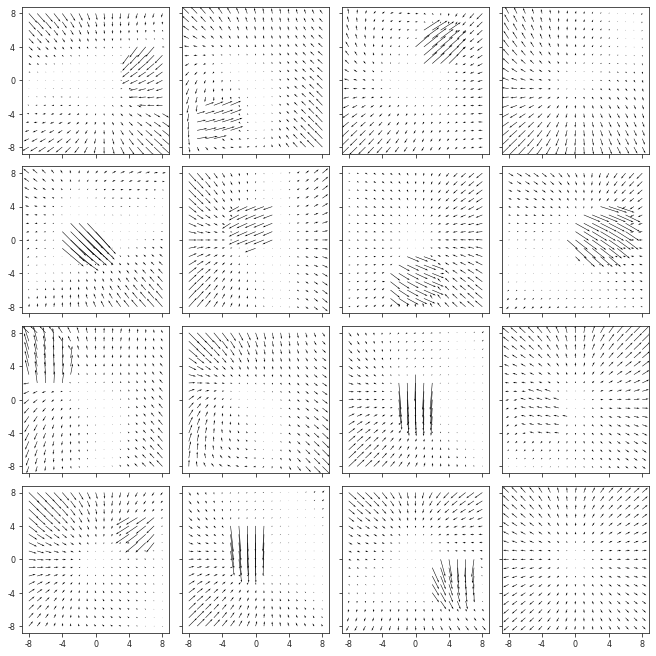

fig/sample (EMA)

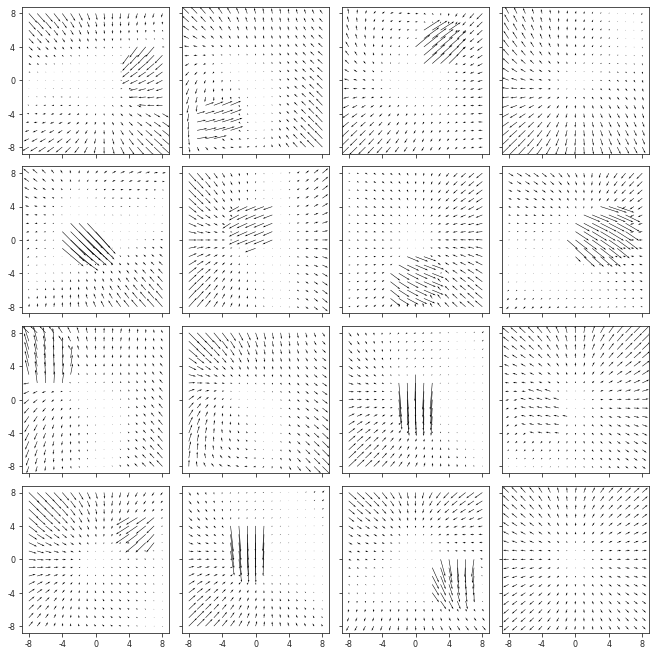

----------------------------------------------------------------------

fig/regression (VAE)

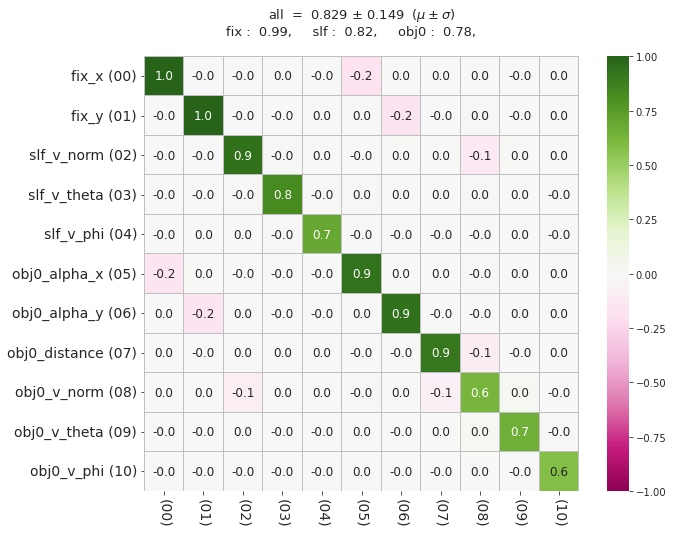

fig/regression (EMA)

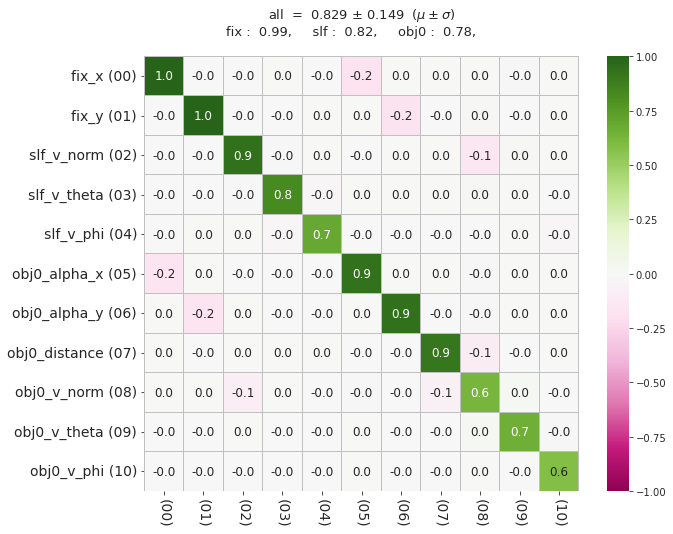

----------------------------------------------------------------------

fig/bar (VAE)

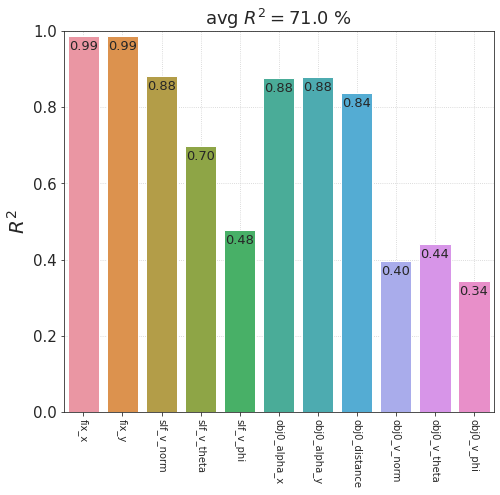

fig/bar (EMA)

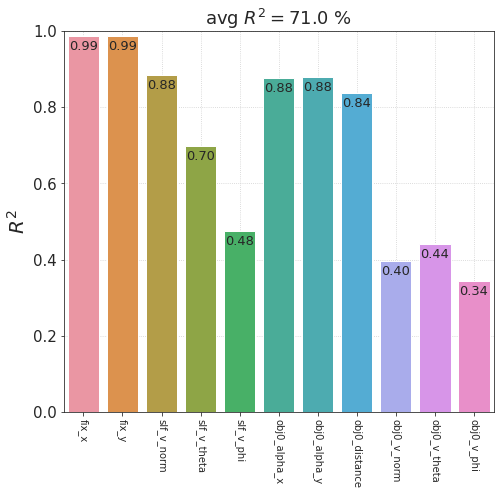

----------------------------------------------------------------------

fig/bar_aux (VAE)

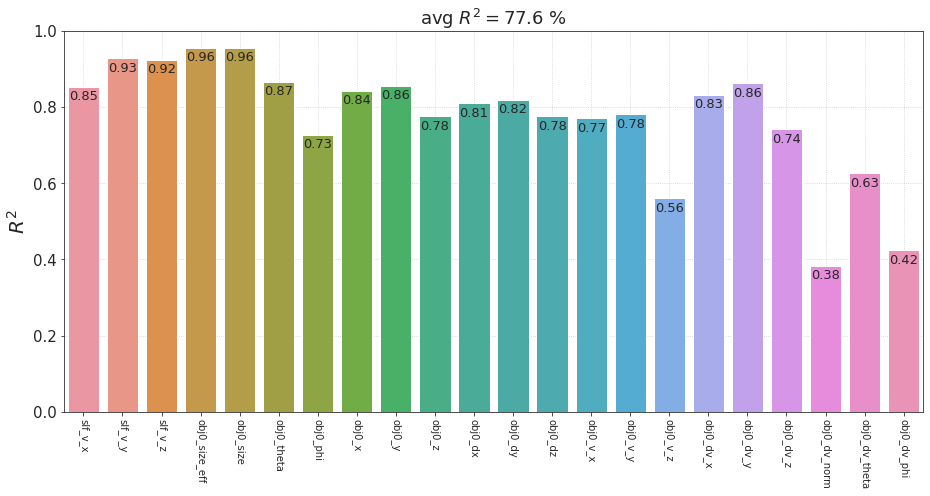

fig/bar_aux (EMA)

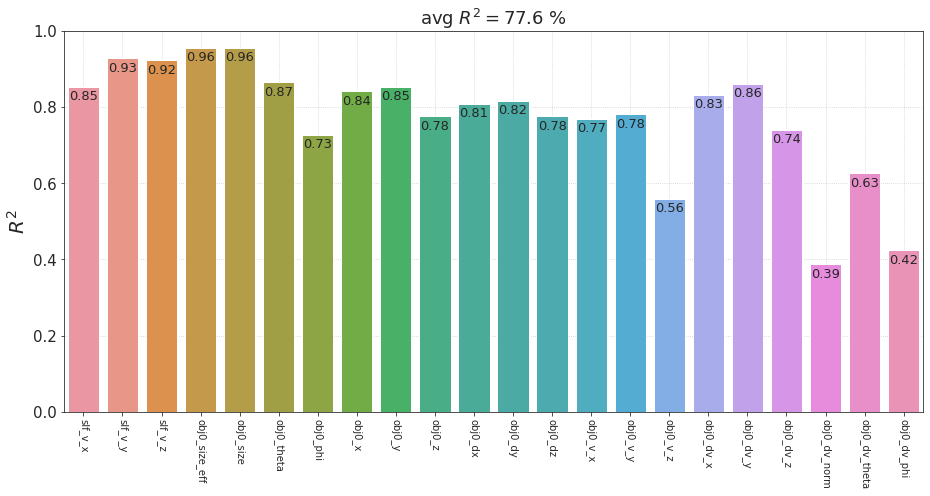

----------------------------------------------------------------------

fig/mutual_info (VAE)

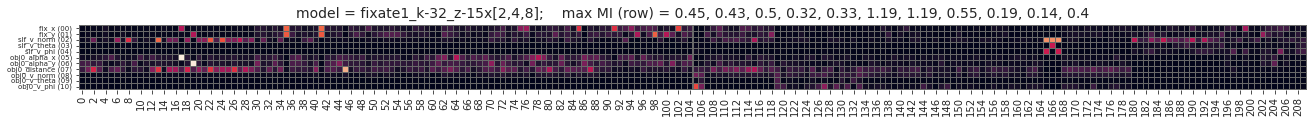

fig/mutual_info (EMA)

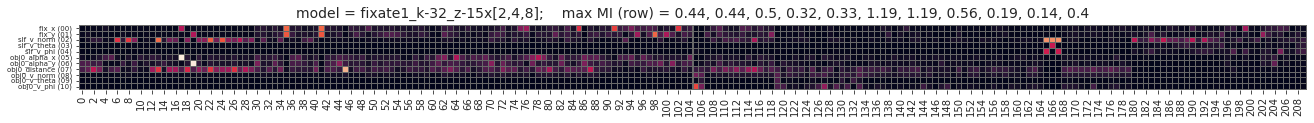

----------------------------------------------------------------------

In [12]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [14]:
np.quantile(list(tr.stats['grad'].values()), [0.5, 0.7, 0.9, 1])

array([8.42274506e+02, 1.61183201e+03, 2.80612398e+04, 1.46506449e+11])

In [15]:
np.quantile(list(tr.stats['loss'].values()), [0.5, 0.7, 0.9, 1])

array([1.11531935e+01, 1.58240302e+01, 7.35964676e+01, 1.66625840e+07])

In [16]:
gamma = np.stack(tr.stats['gamma'])
gamma.shape

(160000, 30)

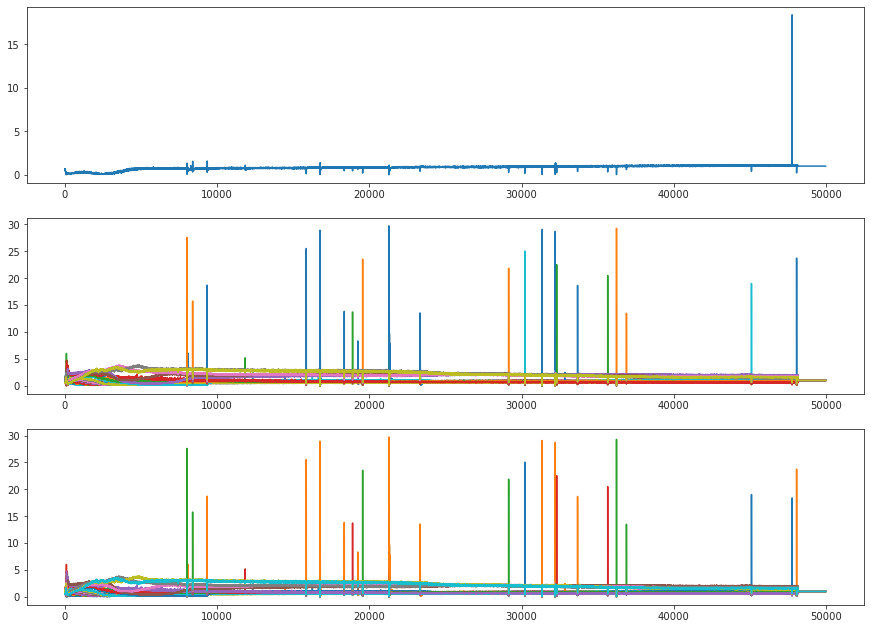

In [17]:
fig, axes = create_figure(3, 1, (15, 11))
axes[0].plot(gamma[:50000, 0])
axes[1].plot(gamma[:50000, 1:])
axes[2].plot(gamma[:50000]);

## DCI

In [17]:
val_ema['regr/r2'], val_ema['regr/r2'].mean(), np.diag(val_ema['regr/r']).mean()

(array([0.98764975, 0.98834234, 0.88452419, 0.6981013 , 0.47586709,
        0.87594402, 0.8804295 , 0.83841145, 0.39558972, 0.44011715,
        0.3427357 ]),
 0.7097920185557776,
 0.8292483923313437)

In [18]:
do_zscore = False
if do_zscore:
    x = sp_stats.zscore(val_ema['z_vld'])
    y = sp_stats.zscore(tr.dl_vld.dataset.g)
    x_tst = sp_stats.zscore(val_ema['z_tst'])
    y_tst = sp_stats.zscore(tr.dl_tst.dataset.g)
else:
    x = val_ema['z_vld']
    y = tr.dl_vld.dataset.g
    x_tst = val_ema['z_tst']
    y_tst = tr.dl_tst.dataset.g

lr = sk_linear.LinearRegression().fit(x, y)
r2_out = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)
r_out = 1 - sp_dist.cdist(
    XA=y_tst.T,
    XB=lr.predict(x_tst).T,
    metric='correlation',
)
r2_out, r2_out.mean(), np.diag(r_out).mean()

(array([0.98765012, 0.9883433 , 0.88463063, 0.69810049, 0.47586489,
        0.87594756, 0.88043098, 0.83841093, 0.39561396, 0.44011209,
        0.34273411]),
 0.7098035510591185,
 0.8292528116636272)

In [19]:
x = val_ema['z_vld'].copy()
y = tr.dl_vld.dataset.g.copy()
x_tst = val_ema['z_tst'].copy()
y_tst = tr.dl_tst.dataset.g.copy()

mu, sd = x.mean(), x.std()
x = (x - mu) / sd
x_tst = (x_tst - mu) / sd

In [20]:
lr = sk_linear.LinearRegression().fit(x, y)
r2_out = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)
r_out = 1 - sp_dist.cdist(
    XA=y_tst.T,
    XB=lr.predict(x_tst).T,
    metric='correlation',
)
r2_out, r2_out.mean(), np.diag(r_out).mean()

(array([0.98764975, 0.98834234, 0.88452419, 0.6981013 , 0.47586709,
        0.87594402, 0.8804295 , 0.83841145, 0.39558972, 0.44011715,
        0.3427357 ]),
 0.7097920185557776,
 0.8292483923313437)

In [21]:
val_ema['regr/r2'].mean(), val_ema['regr/d'].mean(), val_ema['regr/c'].mean()

(0.7097920185557776, 0.26952577, 0.34946582)

In [22]:
from analysis.linear import compute_dci

In [23]:
w = np.abs(lr.coef_)
w *= x.std(0).reshape(1, -1)
w /= y.std(0).reshape(-1, 1)

compute_dci(w)

(0.26952577, 0.34946582)

In [26]:
x.shape, y.shape

((75000, 210), (75000, 11))

In [27]:
importances = np.zeros((11, 210))

for i in tqdm(range(11)):
    _lr = sk_linear.LinearRegression().fit(x, y[:, i])
    result = sk_inspect.permutation_importance(
        _lr, x_tst, y_tst[:, i], n_repeats=5, random_state=0)
    importances[i] = result.importances_mean

  0%|          | 0/11 [00:00<?, ?it/s]

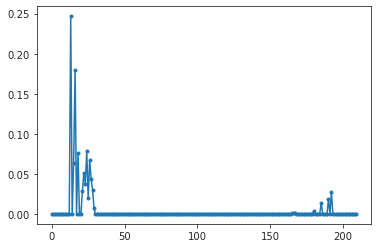

In [28]:
w = np.abs(importances)
rho = w.sum(0) / w.sum()
plt.plot(rho, marker='.')
plt.show()

In [29]:
compute_dci(w)

(0.6992379502481989, 0.6102955591096384)

(0.3747561336550221, 0.7044918165259074)

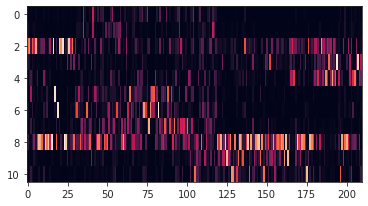

In [30]:
plt.imshow(w / w.sum(0, keepdims=True), aspect=10)

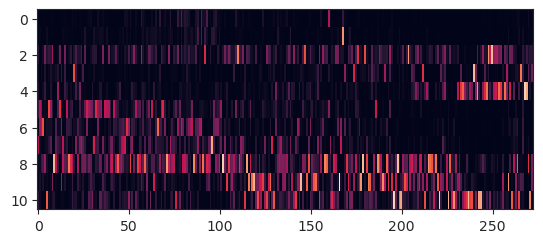

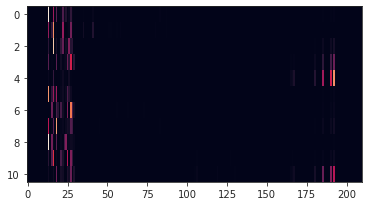

In [31]:
plt.imshow(w / w.sum(1, keepdims=True), aspect=10)

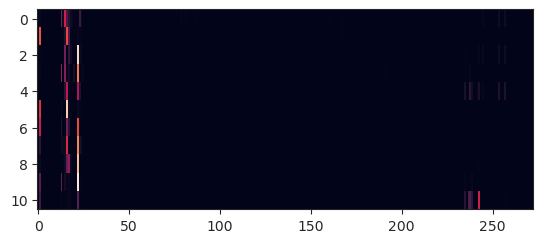

## Imshow Expand

In [32]:
print(vae.expand)

ModuleList(
  (0-1): 2 x DeConv2D(15, 15, kernel_size=(2, 2), stride=(1, 1))
  (2-5): 4 x DeConv2D(15, 15, kernel_size=(4, 4), stride=(1, 1))
  (6-13): 8 x DeConv2D(15, 15, kernel_size=(8, 8), stride=(1, 1))
)

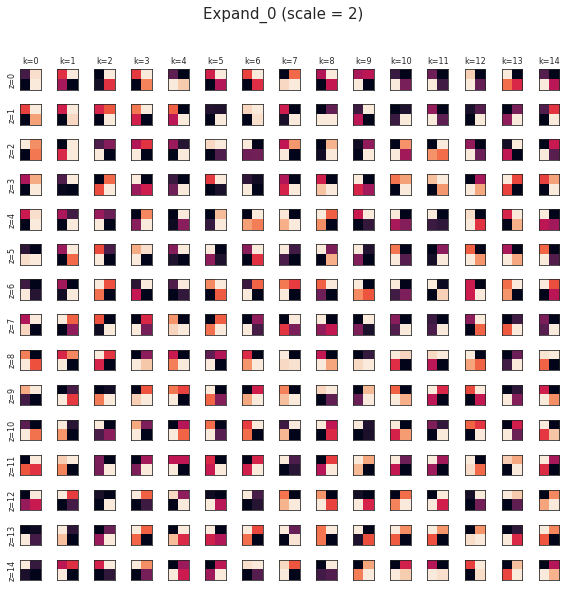

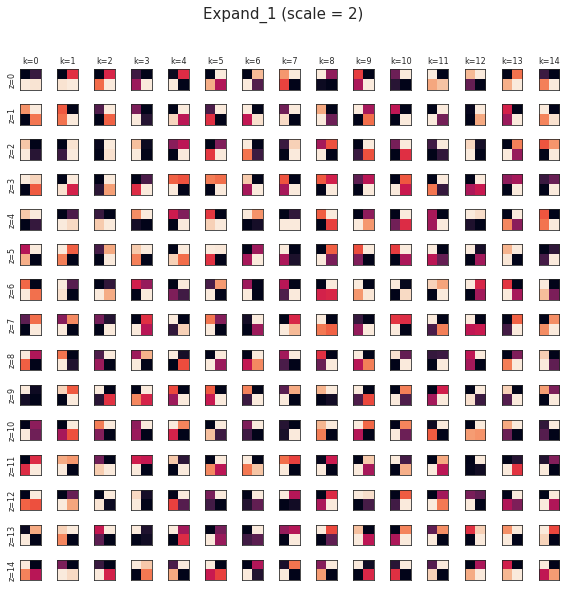

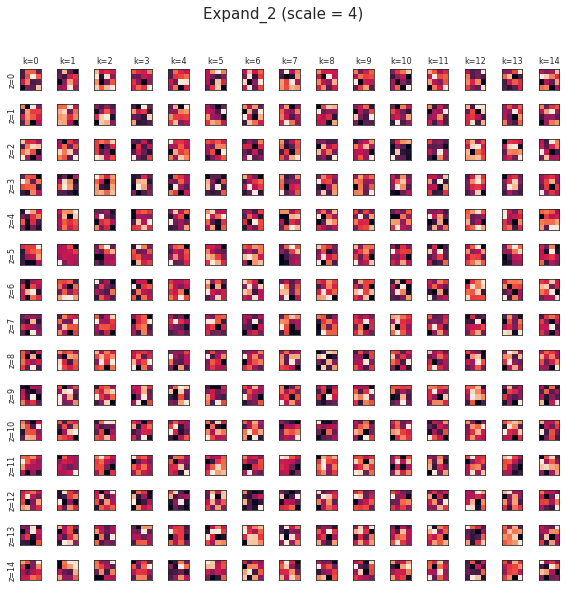

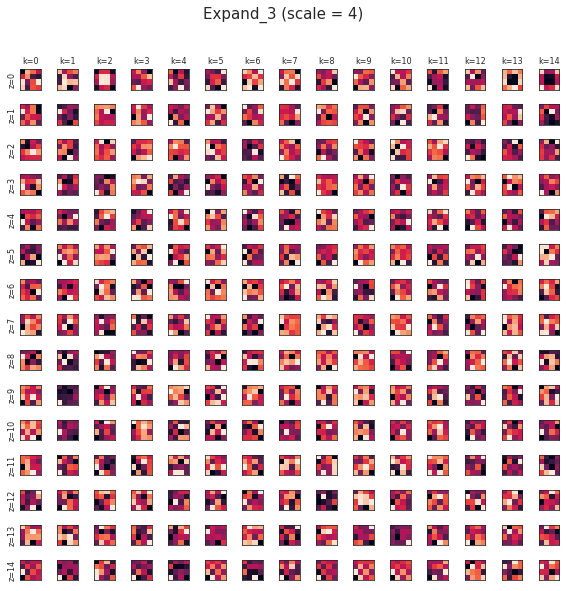

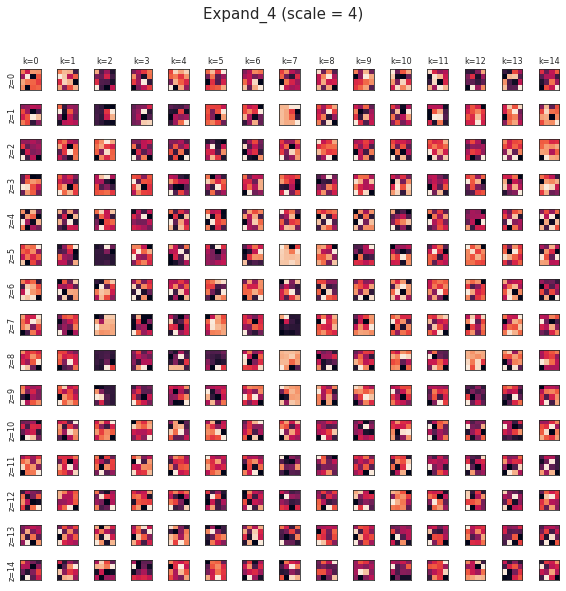

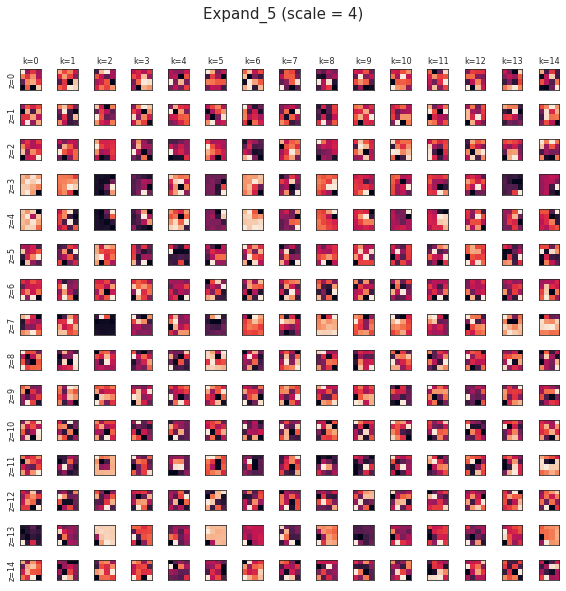

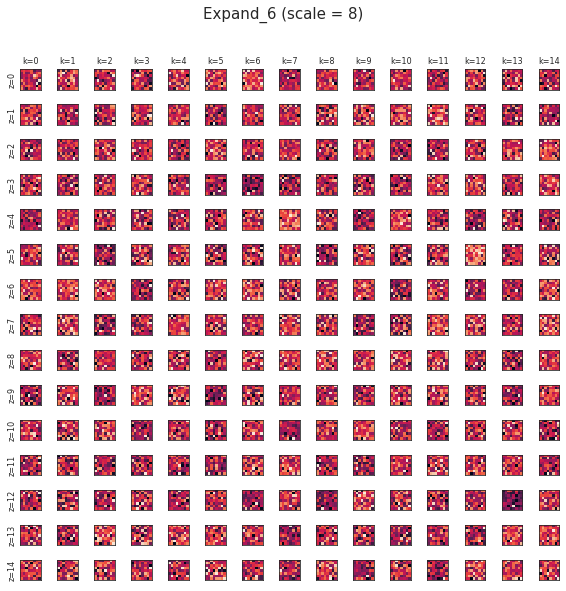

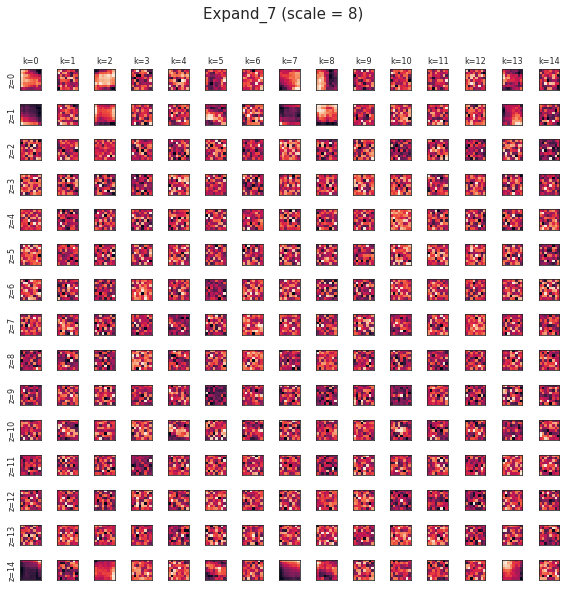

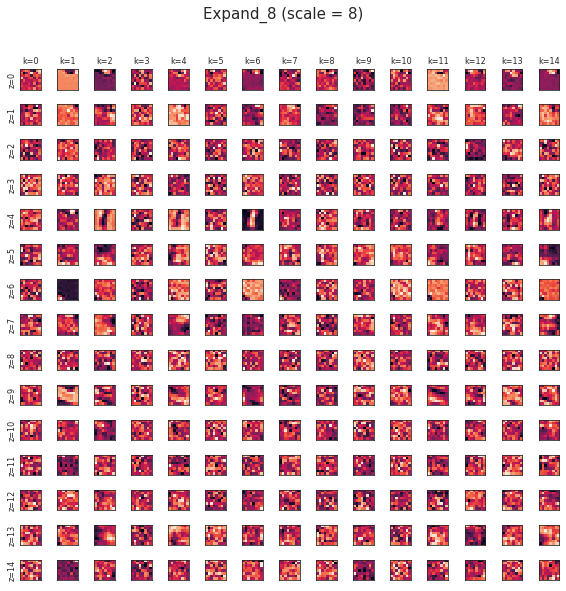

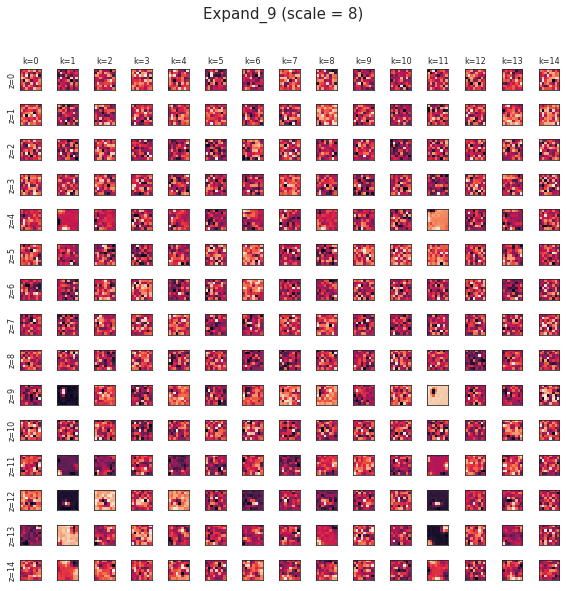

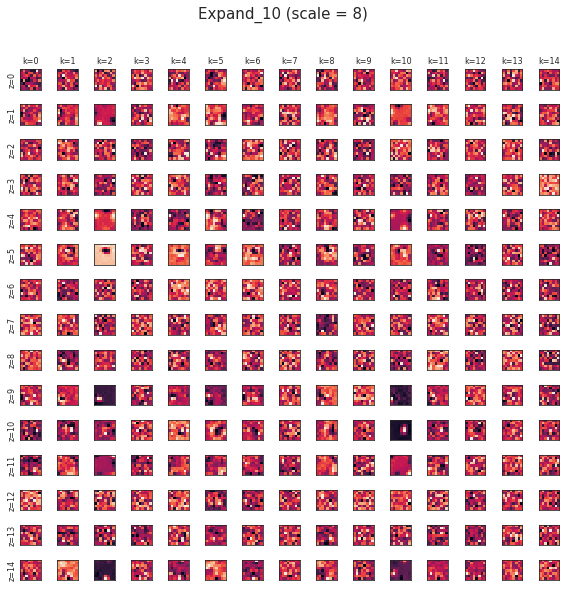

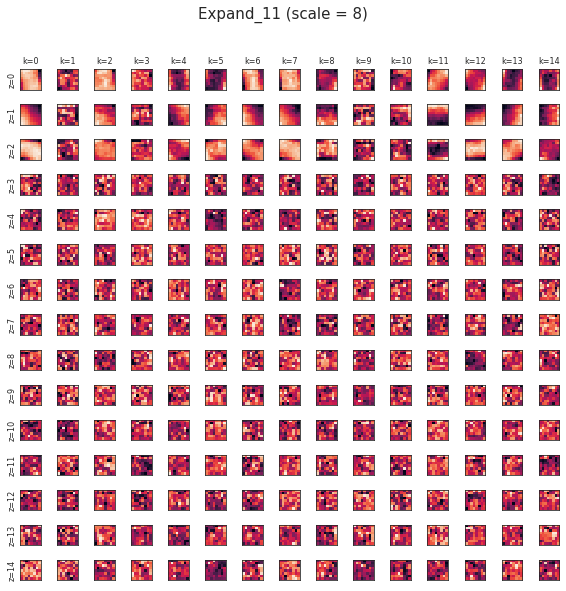

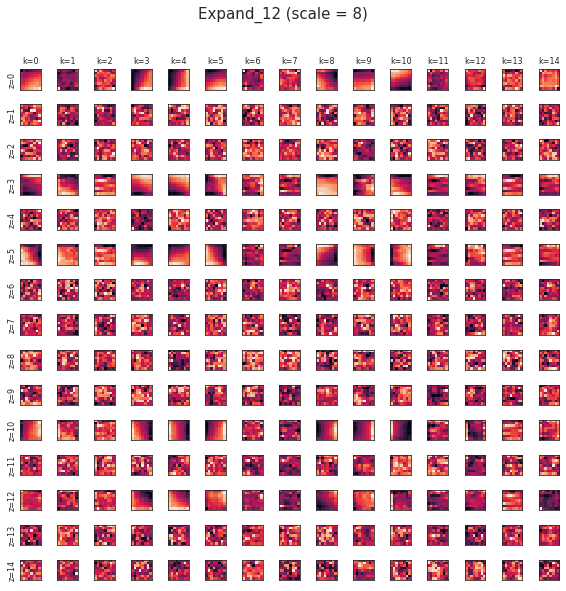

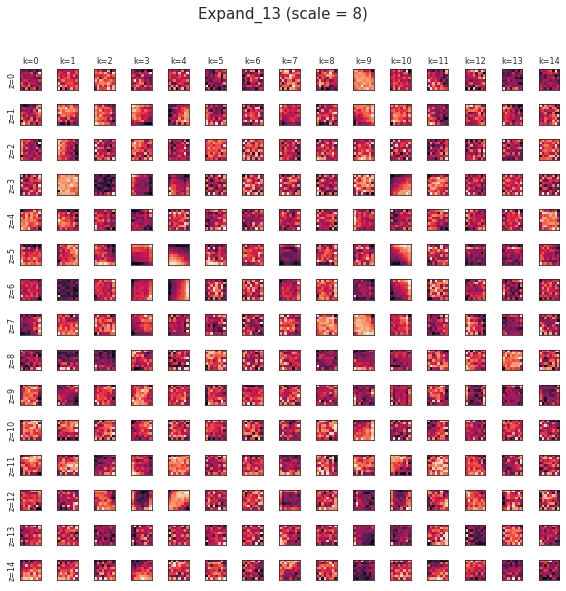

CPU times: user 7min 18s, sys: 1.83 s, total: 7min 20s
Wall time: 7min 20s


In [33]:
%%time

scales, _ = tr.model.latent_scales()
num = vae.cfg.n_latent_per_group

for i, m in enumerate(vae.expand):
    _w = to_np(m.weight)
    fig, axes = create_figure(num, num, (8, 8), 'all', 'all', tight_layout=True)
    for z, k in itertools.product(range(num), range(num)):
        ax = axes[z, k]
        ax.imshow(_w[z, k])
        if z == 0:
            ax.set_title(f"k={k}", fontsize=8)
        if k == 0:
            ax.set_ylabel(f"z={z}", fontsize=8)
    fig.suptitle(f'Expand_{i} (scale = {scales[i]})', fontsize=15, y=1.02)
    remove_ticks(axes, False)
    plt.show()

In [34]:
for i, m in enumerate(vae.expand):
    norm = m.lognorm.exp().detach()
    print({i: norm.mean().item()}, norm)

{0: 1.0070679187774658}
tensor([0.9973, 0.9972, 1.0557, 0.9899, 0.9978, 0.9973, 1.0002, 0.9976, 0.9947,
        0.9972, 1.0224, 1.0401, 0.9979, 0.9973, 1.0235], device='cuda:0')

{1: 0.9289350509643555}
tensor([0.8515, 0.9063, 1.0095, 0.8209, 0.9981, 0.9964, 0.9512, 0.9121, 0.9982,
        0.9082, 0.9976, 0.9967, 0.9613, 0.8015, 0.8244], device='cuda:0')

{2: 0.909349799156189}
tensor([0.7863, 0.8458, 0.9417, 0.8165, 0.8455, 0.8659, 0.9970, 0.8927, 0.9973,
        0.9972, 0.8089, 0.9981, 0.8094, 1.0417, 0.9964], device='cuda:0')

{3: 0.9735289216041565}
tensor([0.9899, 0.9938, 0.9686, 0.9901, 0.9912, 0.9872, 0.9873, 0.9408, 0.9887,
        0.9901, 0.9902, 0.9905, 0.9893, 0.9143, 0.8909], device='cuda:0')

{4: 0.9525869488716125}
tensor([0.9784, 0.9830, 0.9499, 0.9299, 0.9843, 0.8431, 0.9809, 0.8560, 0.9564,
        0.9784, 0.9747, 0.9814, 0.9295, 0.9810, 0.9820], device='cuda:0')

{5: 0.8441882133483887}
tensor([0.9036, 0.8287, 0.9635, 0.7810, 0.9198, 0.8308, 0.7985, 0.8620, 0.7732,
        0.8078, 0.8578, 0.7962, 0.9476, 0.8070, 0.7854], device='cuda:0')

{6: 0.8745331168174744}
tensor([0.8757, 0.8766, 0.8749, 0.8747, 0.8761, 0.8726, 0.8762, 0.8755, 0.8754,
        0.8700, 0.8719, 0.8742, 0.8716, 0.8734, 0.8793], device='cuda:0')

{7: 0.8988422155380249}
tensor([0.9237, 0.9520, 0.9792, 0.9411, 0.9537, 0.8146, 0.9547, 0.8617, 0.6772,
        0.9552, 0.9480, 0.9581, 0.9541, 0.6605, 0.9490], device='cuda:0')

{8: 0.981482982635498}
tensor([0.9802, 1.0831, 0.9533, 0.9857, 0.9340, 0.9904, 1.0106, 0.9853, 0.9861,
        0.9885, 0.9820, 0.9382, 0.9857, 0.9754, 0.9436], device='cuda:0')

{9: 1.0181611776351929}
tensor([0.9869, 1.3294, 0.9763, 0.9853, 0.9820, 0.9871, 0.9799, 0.9809, 0.9434,
        0.9812, 0.9867, 1.2254, 0.9842, 0.9609, 0.9827], device='cuda:0')

{10: 1.0103007555007935}
tensor([0.9788, 0.9448, 1.2955, 0.9830, 0.9694, 0.9229, 0.9641, 0.9847, 0.9307,
        0.9837, 1.2717, 0.9721, 0.9859, 0.9837, 0.9835], device='cuda:0')

{11: 0.9025571942329407}
tensor([0.8527, 1.2731, 0.7619, 0.7506, 0.8339, 0.9877, 0.8930, 0.8388, 0.8540,
        0.8182, 0.8377, 0.9631, 1.0509, 0.9819, 0.8408], device='cuda:0')

{12: 0.9659169912338257}
tensor([0.7996, 0.9431, 0.9997, 0.9082, 0.9188, 0.9079, 0.9889, 0.9896, 0.8542,
        0.7608, 0.7775, 1.1971, 0.8871, 1.6370, 0.9193], device='cuda:0')

{13: 0.9546995162963867}
tensor([0.8900, 1.0067, 0.9896, 0.8469, 0.7550, 1.1668, 1.1580, 0.9005, 1.0145,
        0.9481, 0.7285, 0.9540, 1.0163, 0.9586, 0.9871], device='cuda:0')